In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set()
# sns.set_context('paper', font_scale=0.73)
sns.set_context('paper', font_scale=1.3)
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})

In [2]:
!echo $CONDA_DEFAULT_ENV

In [4]:
#paths
root_dir = "/home/ryan/haveibeentrainedon/models/unstealthy_repetition"
dataset_name = "pile1e9_64"
model_sizes = ["70M", "160M"]
scored_watermark = "scored_watermark_losses.csv"
scored_null = "scored_null_losses.csv"

experiments = [f"{root_dir}/{dataset_name}/{model_size}" for model_size in model_sizes]
experiments

['/home/ryan/haveibeentrainedon/models/unstealthy_repetition/pile1e9_64/70M',
 '/home/ryan/haveibeentrainedon/models/unstealthy_repetition/pile1e9_64/160M']

In [5]:
models = list(filter(lambda x: x[-5:] == "model", os.listdir(experiments[0])))
models = sorted(models, key = lambda x: eval(x[:-6]))
temp_models = []
for model in models:
    temp_models += [model]
models = temp_models
models


['1_model',
 '2_model',
 '4_model',
 '8_model',
 '16_model',
 '32_model',
 '64_model']

In [6]:
experiments_watermark = []
experiments_null = []
for experiment in experiments:
    total_dfs_watermark = []
    total_dfs_null = []
    for model_type in models:
        total_dfs_watermark += [pd.read_csv(os.path.join(experiment, model_type, scored_watermark), header=None)]
        total_dfs_null += [pd.read_csv(os.path.join(experiment, model_type, scored_null), header=None)]
    experiments_watermark.append(total_dfs_watermark)
    experiments_null.append(total_dfs_null)
print(len(experiments_watermark))
print(len(experiments_watermark[0]))

2
7


In [7]:
import numpy as np

experiments_null_mean_distribution = []

for experiment_id in range(len(experiments)):
    total_null_means = []

    for null_distr in experiments_null[experiment_id]:
        null_distr = null_distr.to_numpy().reshape(-1)
        num_per_batch = int(len(null_distr) / 1000)
        null_means = []
        for i in range(1000):
            curr_sample = null_distr[i * num_per_batch: (i+1) * num_per_batch]
            null_means += [curr_sample.mean()]
        total_null_means += [null_means]
    
    experiments_null_mean_distribution.append(total_null_means)
print(np.array(experiments_null_mean_distribution).shape)


(2, 7, 1000)


In [8]:

experiments_watermark_mean = []

for experiment_id in range(len(experiments)):
    total_watermark_means = []
    for watermark_distr in experiments_watermark[experiment_id]:
        watermark_distr = watermark_distr.to_numpy()
        total_watermark_means += [watermark_distr.mean()]
    experiments_watermark_mean.append(total_watermark_means)

print(np.array(experiments_watermark_mean).shape)
print(experiments_watermark_mean)


(2, 7)
[[7.411414623260497, 8.074971199035645, 7.253362178802489, 7.069619596004486, 7.237430363893509, 7.227809086441994, 7.136114738881588], [5.9729084968566895, 7.4320735931396475, 6.9388039112091064, 6.853036105632782, 7.063733398914337, 7.2328304797410965, 7.137492410838604]]


In [9]:
print(experiments_watermark_mean)

[[7.411414623260497, 8.074971199035645, 7.253362178802489, 7.069619596004486, 7.237430363893509, 7.227809086441994, 7.136114738881588], [5.9729084968566895, 7.4320735931396475, 6.9388039112091064, 6.853036105632782, 7.063733398914337, 7.2328304797410965, 7.137492410838604]]


In [10]:
print(np.mean(np.array(experiments_null_mean_distribution[0]), axis = 1))
print(np.std(np.array(experiments_null_mean_distribution[0]), axis = 1))


[7.12960199 7.16137995 7.14852582 7.14910522 7.17940567 7.17398655
 7.13561163]
[0.12147168 0.11970318 0.12421804 0.12994459 0.14384619 0.16808764
 0.94792488]


In [11]:
#we now get the z-score

experiment_z_scores = []

for experiment_id in range(len(experiments)):
    
    curr_z_scores = []

    for watermark_ind in range(len(experiments_watermark_mean[experiment_id])):
        null_distr = np.array(experiments_null_mean_distribution[experiment_id][watermark_ind])
        watermark_score = experiments_watermark_mean[experiment_id][watermark_ind]
        
        curr_z_scores += [(watermark_score - null_distr.mean()) / null_distr.std()]
    
    experiment_z_scores.append(curr_z_scores)

print(np.array(experiment_z_scores).shape)

(2, 7)


In [12]:
x = [1, 2, 4, 8, 16, 32, 64]

In [13]:
experiment_z_scores[0]

[2.3199862315360518,
 7.632138665804197,
 0.8439704547577142,
 -0.6116885945282918,
 0.403380137862943,
 0.32020522736884216,
 0.0005307526991973376]

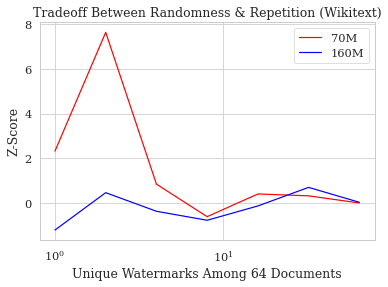

In [16]:
# Create a line plot for each set of y-values
sns.lineplot(x=x, y=experiment_z_scores[0], color='red', label='70M')
ax = sns.lineplot(x=x, y=experiment_z_scores[1], color='blue', label='160M')

# Customize the plot
plt.title('Tradeoff Between Randomness & Repetition (Wikitext)')
plt.xlabel('Unique Watermarks Among 64 Documents')
plt.ylabel('Z-Score')
plt.legend()

ax.set_xscale("log")

# Show the plot
plt.show()